# EE4375-2022: Second Lab Session: Build System Matrix, Build Intergrid Transfer Operators 

## Import Packages  

In [2]:
using LinearAlgebra 
using SparseArrays 

using IterativeSolvers
using Preconditioners

using BenchmarkTools
using Profile
using ProfileView

using Plots 

## Section 1: Build Linear System as Sparse From the Start

In [3]:
function buildMat1D(N::Int64)
  Nm1::Int64 = N-1; Np1::Int64 = N+1 
  h::Float64 = 1/N; h2::Float64 = h*h; 
  stencil = Vector{Float64}([-1/h2, 2/h2, -1/h2]);
  #..Allocate row, column and value vector 
  I = Int64[]; sizehint!(I, 3*Nm1); 
  J = Int64[]; sizehint!(J, 3*Nm1); 
  vals=Float64[]; sizehint!(vals, 3*Nm1);
  intervalRows = Vector{Int64}(2:N);
  for i in intervalRows 
    append!(I, [i,i,i])
    append!(J, [i-1,i,i+1])
    append!(vals,stencil) 
  end 
  #..Build matrix for interior rows   
  A = sparse(I,J,vals,Np1,Np1)
  #..Build matrix for boundary rows
  A[1,1] = 1; A[end,end]=1; A[2,1] =0; A[end-1,end]=0; 
  return A 
end 

buildMat1D (generic function with 1 method)

In [9]:
A = buildMat1D(4)

5×5 SparseMatrixCSC{Float64, Int64} with 11 stored entries:
 1.0     ⋅      ⋅      ⋅    ⋅ 
 0.0   32.0  -16.0     ⋅    ⋅ 
  ⋅   -16.0   32.0  -16.0   ⋅ 
  ⋅      ⋅   -16.0   32.0  0.0
  ⋅      ⋅      ⋅      ⋅   1.0

In [11]:
M = Diagonal(A)

5×5 Diagonal{Float64, SparseVector{Float64, Int64}}:
 1.0    ⋅     ⋅     ⋅    ⋅ 
  ⋅   32.0    ⋅     ⋅    ⋅ 
  ⋅     ⋅   32.0    ⋅    ⋅ 
  ⋅     ⋅     ⋅   32.0   ⋅ 
  ⋅     ⋅     ⋅     ⋅   1.0

## Section 2: Build Two-Grid Restriction Operator 

In [5]:
function buildRestrict1D(N::Int64)
  Nm1::Int64 = N-1; Np1::Int64 = N+1 
  Nc = div(N,2); Ncm1 = Nc-1; Ncp1 = Nc+1; 
  #..Allocate row, column and value vector 
  I = Int64[]; sizehint!(I, 3*Ncm1); 
  J = Int64[]; sizehint!(J, 3*Ncm1); 
  vals=Float64[]; sizehint!(vals, 3*Ncm1);
  #..loop over interior rows 
  for i_c in 2:Nc 
    i_f = 2*i_c-1
    append!(I, [i_c,i_c,i_c])
    append!(J, [i_f-1,i_f,i_f+1])
    append!(vals,[.5 1 0.5]) 
  end 
  #..Build matrix    
  R = sparse(I,J,vals,Ncp1,Np1)
  R[1,1]=1; R[end,end]=1; 
  return R  
end 

buildRestrict1D (generic function with 1 method)

In [6]:
buildRestrict1D(8)

5×9 SparseMatrixCSC{Float64, Int64} with 11 stored entries:
 1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   0.5  1.0  0.5   ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   0.5  1.0  0.5   ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅   0.5  1.0  0.5   ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0

## Section 3: Solve Linear System Using a Basic Iterative Method 

In [13]:
mutable struct Precctx 
    M 
end

In [94]:
function prec_setup(A::AbstractMatrix,prectype)
 
    if (prectype == "none")
        M = 1
        precctx = Precctx(M)
    elseif (prectype == "jacobi")
        M = Diagonal(A)
        precctx = Precctx(M)
    elseif (prectype == "lower-gs")
        M = LowerTriangular(A)
        precctx = Precctx(M)
    elseif (prectype == "upper-gs")
        M = UpperTriangular(A)
        precctx = Precctx(M)                
    elseif (prectype == "two-grid")
    else 
        error("prec_setup: unknown preconditioner type\n")
    end 
    
    return precctx 
    
end 

prec_setup (generic function with 1 method)

In [95]:
A = buildMat1D(4)
#prectype = "jacobi"
prectype = "none"
r = ones(5,1)
precctx = prec_setup(A,prectype)
@show precctx.M 

precctx.M = 1


1

In [96]:
function prec_apply(r,prectype,precctx)
    
    if (prectype == "none")
        z = r
    elseif ((prectype == "jacobi")||(prectype == "lower-gs")||(prectype == "upper-gs"))
        M = precctx.M 
        z = M \ r
    elseif (prectype == "two-grid")
    else 
        error("prec_setup: unknown preconditioner type\n")
    end 
    
    return z 
    
end 

prec_apply (generic function with 1 method)

In [97]:
A = buildMat1D(4)
r = ones(5,1)
prectype = "jacobi"
precctx = prec_setup(A,prectype)
z = prec_apply(r,prectype,precctx)

5×1 Matrix{Float64}:
 1.0
 0.03125
 0.03125
 0.03125
 1.0

In [101]:
function bim!(x, A::AbstractMatrix, b; prectype = "none", maxiter=100)    
  r = b - A*x
  bnrm = norm(b)
  rnorm = norm(r) / bnrm 
  rnormvec = Vector([rnorm]) 
  precctx = prec_setup(A,prectype)
  tol = 1e-6
  iter = 0 
  while ( (rnorm > tol) && (iter<maxiter) )
    z = prec_apply(r,prectype,precctx)
    x+=z
    r = b - A*x
    rnorm = norm(r) / bnrm 
    append!(rnormvec, rnorm)     
    iter+=1
  end 
  return x, rnormvec 
end 

bim! (generic function with 1 method)

## Section 4: Testing BIM Implementation 

In [102]:
N = 128; Np1 = N+1;  
A = buildMat1D(N)
b = ones(Np1)
x = zeros(Np1)
precctx = prec_setup(A,prectype)
x, rnormvec1 = bim!(x,A,b;prectype="jacobi");
x = zeros(Np1)
x, rnormvec2 = bim!(x,A,b;prectype="lower-gs");
x = zeros(Np1)
x, rnormvec3 = bim!(x,A,b;prectype="upper-gs");

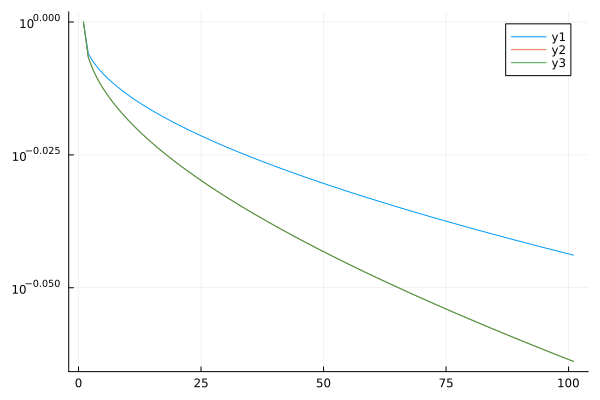

In [103]:
plot(rnormvec1,yscale=:log10)
plot!(rnormvec2,yscale=:log10)
plot!(rnormvec3,yscale=:log10)